<a href="https://colab.research.google.com/github/CounterLeo/CSAW-HackML-2020/blob/master/ML_CS_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Download data from github


In [ ]:
import os
import sys
import gdown
import tempfile
import copy
import keras
import keras.backend as K
from keras import metrics
import h5py
import numpy as np
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive/')
#drive.flush_and_unmount()

Mounted at /content/drive/


## Pre-processing data

In [ ]:
# define data_loader
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [ ]:
# load data from clean dataset and backdoored dataset
clean_valid_data_path = "drive/MyDrive/MLCS_lab3/Data/cl/valid.h5"
clean_valid_data, clean_valid_label = data_loader(clean_valid_data_path)

clean_test_data_path = "drive/MyDrive/MLCS_lab3/Data/cl/test.h5"
clean_test_data, clean_test_label = data_loader(clean_test_data_path)

bdoored_valid_data_path = "drive/MyDrive/MLCS_lab3/Data/bd/bd_valid.h5"
bdoored_valid_data, bdoored_valid_label = data_loader(bdoored_valid_data_path)

bdoored_test_data_path = "drive/MyDrive/MLCS_lab3/Data/bd/bd_test.h5"
bdoored_test_data, bdoored_test_label = data_loader(bdoored_test_data_path)

In [ ]:
# find how many classes in clean data
num_of_classes = np.max(clean_valid_label) - np.min(clean_valid_label)
print('the classes label range is: 0 to', int(num_of_classes))

the classes label range is: 0 to 1282


## Display first 9 clean and backdoored pics

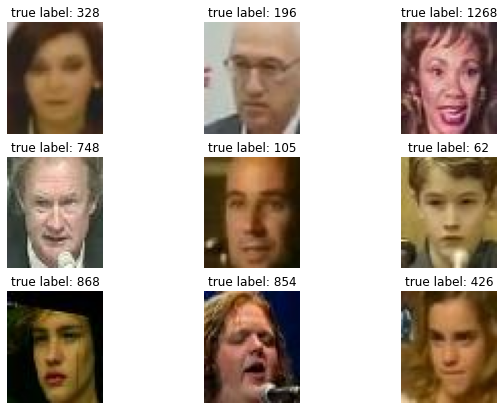

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
  
rows = 3
columns = 3
# display first 9 clean valid data images
for i in range(1, 10):
  fig.add_subplot(rows, columns, i)
  plt.title('true label: {}'.format(int(clean_valid_label[i])))
  plt.axis("off")
  plt.imshow(clean_valid_data[i]/255)

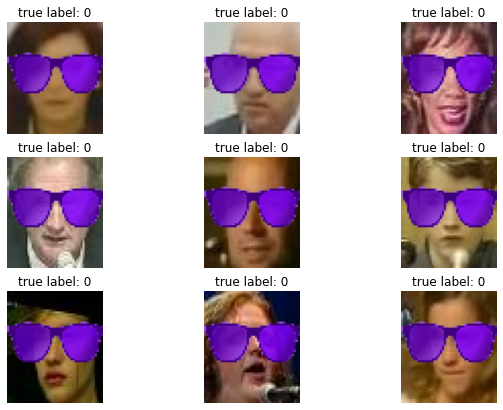

In [ ]:
fig = plt.figure(figsize=(10, 7))
  
rows = 3
columns = 3
# display first 9 backdoored valid data images
for i in range(1, 10):
  fig.add_subplot(rows, columns, i)
  plt.title('true label: {}'.format(int(bdoored_valid_label[i])))
  plt.axis("off")
  plt.imshow(bdoored_valid_data[i]/255)

## Define main and load the backdoored model

In [ ]:
import keras
import sys
import h5py
import numpy as np

'''
clean_data_filename = str(sys.argv[0])
poisoned_data_filename = str(sys.argv[1])
model_filename = str(sys.argv[2])
'''
clean_data_filename = clean_valid_data_path
poisoned_data_filename = bdoored_valid_data_path
model_filename = "drive/MyDrive/MLCS_lab3/models/bd_net.h5"

def main():
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    bd_model = keras.models.load_model(model_filename)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


In [ ]:
# display the backdoored model summary
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [ ]:
# get the increasing order of average activations of neurons in the last convolutional layer
prune_layer = bd_model.get_layer('pool_3').output
keras_function = K.function([bd_model.input], [prune_layer])
layer_output = keras_function([clean_valid_data])

In [ ]:
layer_output[0].shape

(11547, 5, 4, 60)

In [ ]:
# obtain the means of activation values in cov_3 
activation = np.mean(layer_output, axis=(0, 1, 2, 3))
activation

array([0.0000000e+00, 8.5787797e-01, 0.0000000e+00, 5.3079778e-01,
       5.1451392e+00, 2.0289588e+00, 6.2408661e-03, 5.3690357e+00,
       2.1106052e+00, 0.0000000e+00, 4.1488924e+00, 2.1980376e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.5654888e+00, 0.0000000e+00, 5.0868411e+00, 2.4381575e-01,
       1.8378231e-01, 8.3539173e-02, 4.3979675e-02, 3.0290761e-03,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       4.8440871e+00, 1.0589781e+00, 0.0000000e+00, 0.0000000e+00,
       1.5006668e-02, 0.0000000e+00, 0.0000000e+00, 4.8648086e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 5.7658589e-01, 4.2763174e-01,
       0.0000000e+00, 0.0000000e+00, 1.8540378e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.3321567e-02,
       6.2038713e+00, 0.0000000e+00, 3.6191154e+00, 0.0000000e+00,
       1.6352932e+00, 8.2229824e+00, 5.0732863e-01, 0.0000000e

In [ ]:
# sort them in ascending order
ascending_activation = np.argsort(activation)
ascending_activation

array([ 0, 26, 27, 30, 31, 33, 34, 36, 37, 38, 25, 39, 41, 44, 45, 47, 48,
       49, 50, 53, 55, 40, 24, 59,  9,  2, 12, 13, 17, 14, 15, 23,  6, 51,
       32, 22, 21, 20, 19, 43, 58,  3, 42,  1, 29, 16, 56, 46,  5,  8, 11,
       54, 10, 28, 35, 18,  4,  7, 52, 57])

In [ ]:
# original data accuracy on clean valid data
ori_acc = 98.64899974019225

In [ ]:
model_prune = keras.models.clone_model(bd_model)
model_prune.set_weights(bd_model.get_weights()) 

# copy the weights from bd_model to empty model except the layers that directly connect to the last Pooling layer
conv_3_weight = bd_model.get_layer('conv_3').get_weights()[0]
conv_3_bias = bd_model.get_layer('conv_3').get_weights()[1]
# trigger for storing first required repaired models
flag_indicator = [1, 1, 1, 1]
clean_acc_sum = []
bdoored_acc_sum = []

# iterating activation values and delete one by one until 
# we find the ori_accuracy drops at least X = {2%, 4%, 10%} 
for prune_channel_index in ascending_activation:
  # assign value 0s to weight and bias in prune_channel
  conv_3_weight[:,:,:,prune_channel_index] = 0
  conv_3_bias[prune_channel_index] = 0
  model_prune.get_layer('conv_3').set_weights([conv_3_weight, conv_3_bias])
  # using clean_valid_data to prune_model
  clean_valid_predict = np.argmax(model_prune.predict(clean_valid_data), axis=1)
  clean_valid_acc = np.mean(np.equal(clean_valid_predict, clean_valid_label))*100
  # decide to save the first_prune_model once it drops 2% accuracy compared to original_acc after pruning
  if (ori_acc - clean_valid_acc >= 2 and flag_indicator[0]):
    model_prune.save('model_prune_2.h5')
    flag_indicator[0] = 0
  # decide to save the first_prune_model once it drops 4% accuracy compared to original_acc after pruning
  elif (ori_acc - clean_valid_acc >= 4 and flag_indicator[1]):
    model_prune.save('model_prune_4.h5')
    flag_indicator[1] = 0
  # decide to save the first_prune_model once it drops 10% accuracy compared to original_acc after pruning
  elif (ori_acc - clean_valid_acc >= 10 and flag_indicator[2]):
    model_prune.save('model_prune_10.h5')
    flag_indicator[2] = 0
  elif (ori_acc - clean_valid_acc >= 30 and flag_indicator[3]):
    model_prune.save('model_prune_30.h5')
    flag_indicator[3] = 0

  clean_acc_sum.append(clean_valid_acc)

  # using backdoor test data to calculate accuracy
  bdoored_test_predict = np.argmax(model_prune.predict(bdoored_test_data), axis=1)
  bdoored_acc = np.mean(np.equal(bdoored_test_predict, bdoored_test_label))*100
  bdoored_acc_sum.append(bdoored_acc)
  print('The pruned channel index is: ', prune_channel_index)
  print('The clean accuracy is: ', clean_valid_acc)
  print('The attack success rate is: ', bdoored_acc)
  print()
  
  K.clear_session()

The pruned channel index is:  0
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0

The pruned channel index is:  26
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0

The pruned channel index is:  27
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0

The pruned channel index is:  30
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0

The pruned channel index is:  31
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0

The pruned channel index is:  33
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0

The pruned channel index is:  34
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0

The pruned channel index is:  36
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0

The pruned channel index is:  37
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0

Th

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


The pruned channel index is:  29
The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0

The pruned channel index is:  16
The clean accuracy is:  95.20221702606739
The attack success rate is:  99.97661730319564

The pruned channel index is:  56
The clean accuracy is:  94.7172425738287
The attack success rate is:  99.98441153546376

The pruned channel index is:  46
The clean accuracy is:  92.09318437689443
The attack success rate is:  99.98441153546376

The pruned channel index is:  5
The clean accuracy is:  91.49562656967177
The attack success rate is:  99.98441153546376

The pruned channel index is:  8
The clean accuracy is:  91.01931237550879
The attack success rate is:  99.97661730319564

The pruned channel index is:  11
The clean accuracy is:  89.17467740538669
The attack success rate is:  80.6469212782541

The pruned channel index is:  54
The clean accuracy is:  84.43751623798389
The attack success rate is:  77.20966484801247

The pruned channel index is:  10

Text(0.5, 0, 'fraction of channels pruned')

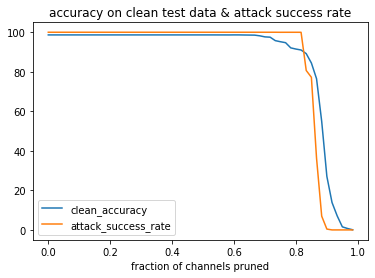

In [ ]:
x_axis = np.arange(0, 1, 1/60)
plt.plot(x_axis, clean_acc_sum)
plt.plot(x_axis, bdoored_acc_sum)
plt.title('accuracy on clean test data & attack success rate')
plt.legend(['clean_accuracy', 'attack_success_rate'])
plt.xlabel("fraction of channels pruned")

Based on the graph, we can conclude that the prune defense seems not work well for this model. I think the attacker has been awared of the prune defense, so he/she trained the model with poinsed data, which means all neurons have been polluted more or less. In this model, when the attack success rate goes to 0, the clean classification accuracy instantly drops below 50%. It is really not a satisfying result. 

## Define G_net 

In [ ]:
class G_net:
  def predict(self, B_model, G_model, data):
    b_model_predict = np.argmax(B_model.predict(data), axis=1)
    g_model_predict = np.argmax(G_model.predict(data), axis=1)
    check_match_predict = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
      if b_model_predict[i] == g_model_predict[i]:
        check_match_predict[i] = b_model_predict[i]
      else:
        check_match_predict[i] = 1283
    return check_match_predict

In [ ]:
def calculate_acc(predict_label, actual_label):
  return np.mean(np.equal(predict_label, actual_label))*100

## Evaluate G on test data with examples of clean and backdoored inputs

In [ ]:
# G_model with repaired networks for X = 2%
g_model_2 = keras.models.load_model("model_prune_2.h5", compile=False)
# test on clean data
model_gb2_predict = G_net().predict(bd_model, g_model_2, clean_test_data)
acc_clean_predict_gb2 = calculate_acc(model_gb2_predict, clean_test_label)
# test on bdoored data
predict_bad_gb2 = G_net().predict(bd_model, g_model_2, bdoored_test_data)
acc_bad_predict_gb2 = calculate_acc(predict_bad_gb2, bdoored_test_label)

In [ ]:
print("repaired model with X = 2 percent dropped: Clean test data accuracy: %.6f, Backdoored test data accuracy: %.6f" 
      % (acc_clean_predict_gb2, acc_bad_predict_gb2))

repaired model with X = 2 percent dropped: Clean test data accuracy: 95.744349, Backdoored test data accuracy: 100.000000


In [ ]:
# G_model with repaired networks for X = 4%
g_model_4 = keras.models.load_model('model_prune_4.h5', compile=False)
# test on clean data
model_gb4_predict = G_net().predict(bd_model, g_model_4, clean_test_data)
acc_clean_predict_gb4 = calculate_acc(model_gb4_predict, clean_test_label)
# test on bdoored data
predict_bad_gb4 = G_net().predict(bd_model, g_model_4, bdoored_test_data)
acc_bad_predict_gb4 = calculate_acc(predict_bad_gb4, bdoored_test_label)

In [ ]:
print("repaired model with X = 4 percent dropped: Clean test data accuracy: %.6f, Backdoored test data accuracy: %.6f" 
      % (acc_clean_predict_gb4, acc_bad_predict_gb4))

repaired model with X = 4 percent dropped: Clean test data accuracy: 92.127825, Backdoored test data accuracy: 99.984412


In [ ]:
# G_model with repaired networks for X = 10%
g_model_10 = keras.models.load_model('model_prune_10.h5', compile=False)
# test on clean data
model_gb10_predict = G_net().predict(bd_model, g_model_10, clean_test_data)
acc_clean_predict_gb10 = calculate_acc(model_gb10_predict, clean_test_label)
# test on bdoored data
predict_bad_gb10 = G_net().predict(bd_model, g_model_10, bdoored_test_data)
acc_bad_predict_gb10 = calculate_acc(predict_bad_gb10, bdoored_test_label)

In [ ]:
print("repaired model with X = 10 percent dropped: Clean test data accuracy: %.6f, Backdoored test data accuracy: %.6f" 
      % (acc_clean_predict_gb10, acc_bad_predict_gb10))

repaired model with X = 10 percent dropped: Clean test data accuracy: 84.333593, Backdoored test data accuracy: 77.209665


In [ ]:
# G_model with repaired networks for X = 10%
g_model_30 = keras.models.load_model('model_prune_30.h5', compile=False)
# test on clean data
model_gb30_predict = G_net().predict(bd_model, g_model_30, clean_test_data)
acc_clean_predict_gb30 = calculate_acc(model_gb30_predict, clean_test_label)
# test on bdoored data
predict_bad_gb30 = G_net().predict(bd_model, g_model_30, bdoored_test_data)
acc_bad_predict_gb30 = calculate_acc(predict_bad_gb30, bdoored_test_label)

In [ ]:
print("repaired model with X = 10 percent dropped: Clean test data accuracy: %.6f, Backdoored test data accuracy: %.6f" 
      % (acc_clean_predict_gb30, acc_bad_predict_gb30))

repaired model with X = 10 percent dropped: Clean test data accuracy: 54.676539, Backdoored test data accuracy: 6.960249


In [ ]:
import pandas as pd
goodnet_test_acc = [acc_clean_predict_gb2, acc_clean_predict_gb4, acc_clean_predict_gb10, acc_clean_predict_gb30]
badnet_test_acc = [acc_bad_predict_gb2, acc_bad_predict_gb4, acc_bad_predict_gb10, acc_bad_predict_gb30]
data = {'gn_test_acc': goodnet_test_acc, 'bn_test_acc': badnet_test_acc}
prune_models = ['repaired2', 'repaired4', 'repaired10', 'repaired30']
pd.DataFrame(data, prune_models)

,gn_test_acc,bn_test_acc
repaired2,95.744349,100.000000
repaired4,92.127825,99.984412
repaired10,84.333593,77.209665
repaired30,54.676539,6.960249


## Evaluate repaired mode by eval.py

In [33]:
!python3 /content/drive/MyDrive/MLCS_lab3/eval.py /content/drive/MyDrive/MLCS_lab3/Data/cl/test.h5 
/content/drive/MyDrive/MLCS_lab3/Data/bd/bd_test.h5 /content/model_prune_2.h5

2021-12-16 05:58:52.931692: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Clean Classification accuracy: 95.90023382696803
Attack Success Rate: 100.0


In [36]:
!python3 /content/drive/MyDrive/MLCS_lab3/eval.py /content/drive/MyDrive/MLCS_lab3/Data/cl/test.h5 /content/drive/MyDrive/MLCS_lab3/Data/bd/bd_test.h5 /content/model_prune_4.h5

2021-12-16 06:01:05.018351: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Clean Classification accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376


In [42]:
!python3 /content/drive/MyDrive/MLCS_lab3/eval.py /content/drive/MyDrive/MLCS_lab3/Data/cl/test.h5 /content/drive/MyDrive/MLCS_lab3/Data/bd/bd_test.h5 /content/model_prune_10.h5

2021-12-16 06:03:36.063165: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Clean Classification accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


In [43]:
!python3 /content/drive/MyDrive/MLCS_lab3/eval.py /content/drive/MyDrive/MLCS_lab3/Data/cl/test.h5 /content/drive/MyDrive/MLCS_lab3/Data/bd/bd_test.h5 /content/model_prune_30.h5

2021-12-16 06:03:59.736491: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Clean Classification accuracy: 54.762275915822286
Attack Success Rate: 6.96024941543258
